In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
import pickle
import numpy as np
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs, plot_metric

# Utils

In [ ]:
def plot_gain_dist_by_episode(names, labels=None, title=None, wind_dirs=[45, 90, 135, 180, 225, 270, 315]):
  if not isinstance(names, list):
    names = [names]

  n_envs = len(wind_dirs)
  n_rows = n_envs // 4 + 1
  n_cols = 4
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), dpi=200)

  for env_id, wind_dir in enumerate(wind_dirs):
    axs_x = env_id // 4
    axs_y = env_id % 4
    ax = axs[axs_x, axs_y]
    ax.set_title(f'Wind dir: {wind_dir}°')
    plot_metric(
      [f'{name}-{env_id}/0' for name in names],
      metric='obs/cum_obs/gain_dist/0',
      y_label=f'Cum. Dist',
      ax=ax,
      hide_legend=True,
      plot_type='mean')

  for i, name in enumerate(names):
    if labels is not None:
      label = labels[i]
    else:
      label = name
    axs[1, 3].plot([], [], label=label)

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  fig.suptitle(title or name)
  fig.legend(loc='upper center',
              bbox_to_anchor=(0.5, -.05),
              ncol=len(names))

In [594]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None, eval=True, show_reward=False):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)
  if len(files) == 0:
    files = glob(f'../runs/{name}')

  print(f'Found {len(files)} files')

  folder = 'eval' if eval else 'train'

  by_wind = defaultdict(list)
  by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/{folder}-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/vmc/0'].iloc[-1]*.1
      if show_reward:
        cum_reward = df[f'reward'].sum()
      else:
        cum_reward = 0
      by_wind[wind_dir].append((score, cum_reward))
      by_step[step].append((score, cum_reward))

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['name', 'env_name', 'seed', 'reward_kwargs', 'policy_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score', 'Mean cum. reward']
  for step, data in by_step.items():
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores), np.mean(cum_reward)])
  print(pt)
  print()

  steps = list(sorted(steps))

  if show_reward:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
  else:
    fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    axs = [axs]
  for wind_dir in wind_dirs:
    data = by_wind[wind_dir]
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    axs[0].plot(steps, scores, label=f'{wind_dir}°')
    if show_reward:
      axs[1].plot(steps, cum_reward)
  axs[0].set_xlabel('Training step')
  if show_reward:
    axs[1].set_xlabel('Training step')
  axs[0].set_ylabel('Cum. dist.')
  axs[0].set_ylabel('Cum. reward')
  fig.suptitle(name)
  # right legend
  fig.legend(bbox_to_anchor=(1.05, .5), loc='center left')

In [ ]:
# def extract_step(filename):
#   res = re.search(r'(\d+)$', filename)
#   return int(res.group(1))

# files = glob('../runs/08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1*')
# files = sorted(files, key=extract_step)

# plot_gain_dist_by_episode(
#   names=[f'{f}/eval-*' for f in files],
#   labels=[f'{round(extract_step(f)/1e3)}K'  for f in files]
# )

# Reflexions

## VMC > gain_dist (maybe)
VMC seems better than gain_dist because it is more stable

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/gain_dist/0'].plot(label='gain_dist')
(df['obs/vmc/0']*.1).plot(label='vmc')
plt.legend()

## Remove noisy sensors

- **TAE -> heading error**: TAE is really noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/tae/0'].plot(label='tae')
plt.legend()

## $\lvert \dot\theta_{rudder} \rvert \leq 6$

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='dt_theta_rudder')
plt.legend()

# $\lvert VMC \rvert \lessapprox .4$

In [ ]:
dfs = get_dfs('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A-9940/eval-*-1/0')
df = dfs.popitem()[1]
df['obs/vmc/0'].plot()

In [ ]:
dfs = get_dfs('08-30-B1-69972/eval-*-0/0')
df = dfs.popitem()[1]
df['obs/cum_obs/g']

# Eval 1M steps with best hyperparams
- **Result:** degredation of performance
- **Hypothesis:** the observation was too big and possibly noisy

In [ ]:
plot_training_evolution('08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1-fix-1', model_folder='08-29-max-wind-v3-scenario-0-T-1_000_000-n-envs-7-1')

# Testing with smaller observation space (basic_2d_obs_v4) & trying with different episode duration

- **Result:** Full episode duration is better. At the end the training "crashed" because is learn to take good direction to maximize the velocity but did not learn yet to be safe about the corridor. Moreover, I find out that the observation/reward was noisy.
- **Hypothesis:** Need larger training time and stable observation/reward

## Episode duration = **200s**

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A"

screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B"
```

In [ ]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-0B')

## Episode duration = **100s**

```bash
screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A"

screen -d -S drl-1 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=100 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B"
```

In [ ]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-1B')

## Episode duration = **50**

```bash
screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A"

screen -d -S drl-2 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_dist_v3 --obs=basic_2d_obs_v4 --total=10000 --n-envs=7 --episode-duration=50 --name="08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B"
```

In [ ]:
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2A')
plt.show()
plot_training_evolution('08-30-rew_v3-obs_v4-scen_0-T_10000-env_7-ep-2B')

# Testing with stable observations and VMC reward
- **Last score: 62**
- **Changes:**
  - **gain dist -> VMC**: VMC reward is more stable than gain dist
  - **TAE-> heading error**: TAE is noisy at the beginning because the velocity vector is not well defined (as the sailboat is not moving).
- **Results:** VMC + 0.01 * heading error seems better (more stable)

## VMC + .001*penalty

In [ ]:
plot_training_evolution('08-30-B1')

## VMC + .005*penalty

In [ ]:
plot_training_evolution('08-30-B2')

## VMC + .01*penalty

In [ ]:
plot_training_evolution('08-30-B3')

## VMC + .05*penalty

In [ ]:
plot_training_evolution('08-30-B4')

## VMC + .1*penalty

In [ ]:
plot_training_evolution('08-30-B5')

## VMC + .5*penalty

```bash
screen -d -S drl-0 -m python3 scripts/sb3_train.py --policy-kwargs="{'net_arch': dict(pi=[256, 256], vf=[256, 256]), 'activation_fn': nn.ReLU, 'ortho_init': False}" --batch-size=32 --n-steps=1024 --gamma=0.999 --gae-lambda=.9 --max-grad-norm=0.6 --learning-rate=3e-05 --vf-coef=0.2 --n-epochs=10 --wind=constant --water-current=none --wind-dirs="[45, 90, 135, 180, 225, 270, 315]" --reward=max_vmc_v1 --obs=basic_2d_obs_v4 --total=100000 --n-envs=7 --name="08-30-B6"
```

In [ ]:
plot_training_evolution('08-30-B6')

# Trying with greater learning rate but **3e-5** seems the best
**Last score:** 63

In [ ]:
plot_training_evolution('08-30-C3-2')

In [ ]:
plot_training_evolution('08-30-C3')

# Trying with different network architecture the original one seems the best
**Last score:** 63

In [ ]:
plot_training_evolution('08-30-D0')

In [ ]:
plot_training_evolution('08-30-D1')

In [ ]:
plot_training_evolution('08-30-D2')

# Debug: why does E0 is not learning? Probably because of the sparse reward
**Last score:** 71.6

In [ ]:
plot_training_evolution('08-30-E0')

In [ ]:
plot_training_evolution('08-31-debug-E0')

In [ ]:
from utils import plot_metric

plot_metric(
  [
    # '08-31-debug-E0-994/**/*',
    # '08-31-debug-E0-3976/**/*',
    # '08-31-debug-E0-6958/**/*',
    # '08-30-E0-19992/**/*',
    # '08-31-debug-2-E0-19950/**/*',

    # '08-31-debug-2-E0-1995/**/*',
    # '08-31-debug-2-E0-3990/**/*',
    # '08-31-debug-2-E0-5985/**/*',
    # '08-31-debug-2-E0-7980/**/*',
    # '08-31-debug-2-E0-9975/**/*',
    # '08-31-debug-2-E0-11970/**/*',
    # '08-31-debug-2-E0-13965/**/*',
    # '08-31-debug-2-E0-15960/**/*',
    # '08-31-debug-2-E0-17955/**/*',
    '08-31-debug-2-E0-19950/**/*',
  ],
  metric='act/mlp')

In [ ]:
plot_metric(
  [
    '08-30-E0-9996/**/*',
    '08-30-E0-19992/**/*',
  ],
  metric='act/mlp')

# Creating a shaped reward

## 2D reward (max vmc & min xte)

In [ ]:
vmc = np.linspace(-1, 1, 100)
xte = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(vmc, xte)

r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1

R = r_vmc + r_xte

plt.contourf(X, Y, R, levels=20)
plt.xlabel('VMC')
plt.ylabel('XTE')
plt.colorbar()

## 3D reward (max vmc & min xte & min heading error)

In [ ]:
import numpy as np
import plotly.graph_objects as go

n = 10

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1.5))
tae = np.linspace(-np.pi, np.pi, int(n*2*np.pi))

X, Y, Z = np.meshgrid(vmc, xte, tae)
r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1
r_tae = 2*(np.exp(np.cos(Z)+1) - 1) / (np.exp(2) - 1) - 1

R = r_vmc + r_xte + r_tae

# Convert the R values into a color
colorscale = 'Viridis'
color = R.flatten()

# Plotting the data
fig = go.Figure(data=[go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode='markers',
    marker=dict(
        size=2,
        color=color,                # set color to an array/list of desired values
        colorscale=colorscale,      # choose a colorscale
        opacity=0.8,
        colorbar=dict(
            title='R Value'       # colorbar title
        )
    )
)])

# Update layout for axis labels and other settings
fig.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),
    scene=dict(
        xaxis_title='VMC',
        yaxis_title='XTE',
        zaxis_title='TAE'
    )
)

fig.show()

## 1D reward (min xte)
- **Idea:** Reward the agent to be inside the corridor

In [ ]:
xte = np.linspace(-3, 3, 100)

r = (np.exp(-((xte)**2-1))-1) / (np.e - 1)

plt.plot(xte, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

In [ ]:
xte = np.linspace(-3, 3, 100)

r = 2*(np.exp(-((xte)**2-1))-1) / (np.e - 1) - 1

plt.plot(xte, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

## Special reward

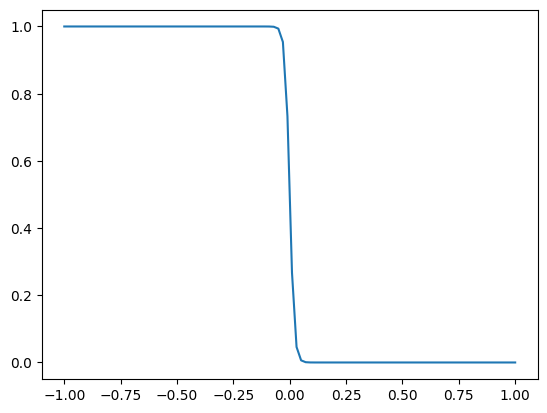

In [1104]:
x = np.linspace(-1, 1, 100)

def f_sigm_bounded(a, x, bound=[-1,1]):
  def sig(x):
    return 1/(1+np.exp(-a*x))
  return (1-sig(x) - sig(bound[0])) / (sig(bound[1])-sig(bound[0]))

plt.plot(x, center_bounded_sig(100, x))

### XTE

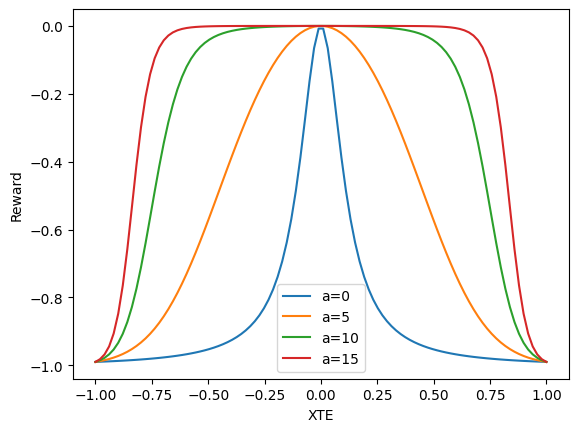

In [1152]:
xte = np.linspace(-1, 1, 100)

def xte_reward(xte, a=5):
  return f_sigm_inf(a, xte**2) - 1

for a in np.linspace(0.5, 15, 4):
  r = xte_reward(xte, a)
  plt.plot(xte, r, label=f'a={a:.0f}')

plt.xlabel('XTE')
plt.ylabel('Reward')
plt.legend()

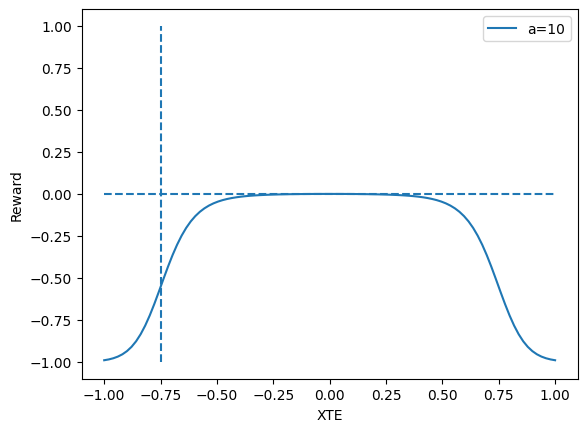

In [1159]:
xte = np.linspace(-1, 1, 100)

a = 10
r = xte_reward(xte, a)
plt.plot(xte, r, label=f'a={a:.0f}')

plt.xlabel('XTE')
plt.ylabel('Reward')
plt.vlines(-.75, -1, 1, linestyles='dashed')
plt.hlines(0, -1, 1, linestyles='dashed')
plt.legend();

### VMC

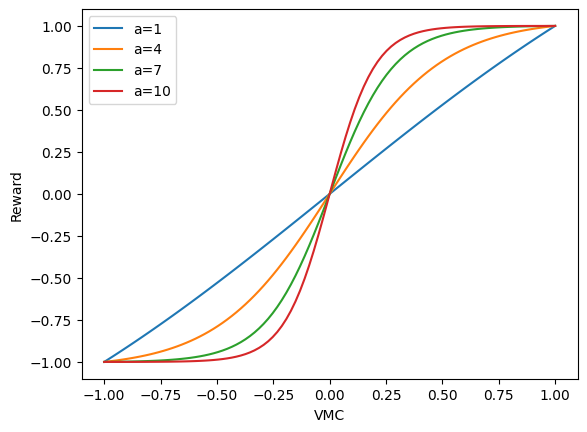

In [1139]:
vmc = np.linspace(-1, 1, 100)

def vmc_reward(vmc, a=1):
  return 2*(1-f_sigm_bounded(a, vmc)) - 1

for a in np.linspace(1, 10, 4):
  r = vmc_reward(vmc, a)
  plt.plot(vmc, r, label=f'a={a:.0f}')

plt.xlabel('VMC')
plt.ylabel('Reward')
plt.legend()

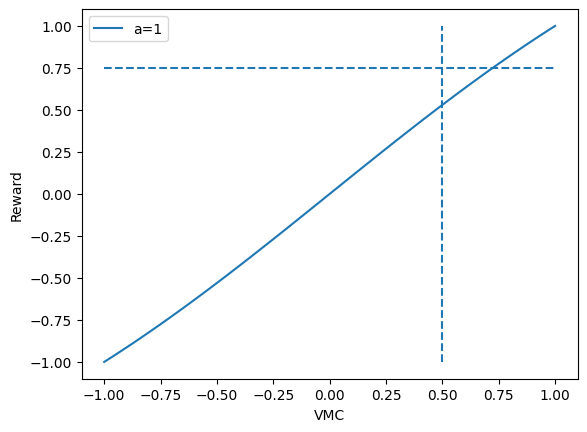

In [1160]:
vmc = np.linspace(-1, 1, 100)

a = 1
r = vmc_reward(vmc, a)
plt.plot(vmc, r, label=f'a={a:.0f}')

plt.xlabel('VMC')
plt.ylabel('Reward')
plt.vlines(0.5, -1, 1, linestyles='dashed')
plt.hlines(0.75, -1, 1, linestyles='dashed')
plt.legend()

-1.0 1.0
-0.999999999927332 -6.795002681636575e-07
0.9999993204997318 -1.999999999927332


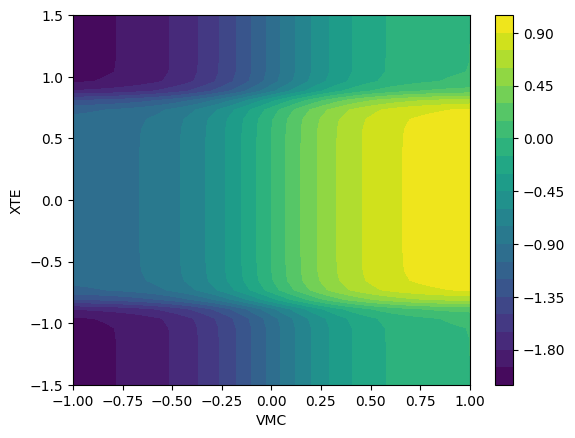

In [1149]:
n = 20

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

# VMC reward
r_vmc = vmc_reward(X, a=4)
print(r_vmc.min(), r_vmc.max())

# XTE penalty:
r_xte = xte_reward(Y, a=15)
print(r_xte.min(), r_xte.max())

R = r_vmc + r_xte

print(R.max(), R.min())

plt.contourf(X, Y, R, levels=20)
plt.xlabel('VMC')
plt.ylabel('XTE')
plt.colorbar()

In [1150]:
n = 20

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))

X, Y = np.meshgrid(vmc, xte)

# VMC reward
r_vmc = vmc_reward(X, a=4)
print(r_vmc.min(), r_vmc.max())

# XTE penalty:
r_xte = xte_reward(Y, a=15)
print(r_xte.min(), r_xte.max())

R = r_vmc + r_xte

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=R, x=X, y=Y)])
fig.update_layout(title='3D Surface Plot of R', autosize=False,
                  width=500, height=500, margin=dict(t=40, b=40, l=40, r=40),
                  scene=dict(xaxis_title='VMC', yaxis_title='XTE', zaxis_title='R'),
                  scene_camera=dict(
                      up=dict(x=0, y=0, z=1),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1.5, y=1.5, z=1.5)
                  ))
fig.show()

-1.0 1.0
-0.999999999927332 -6.795002681636575e-07


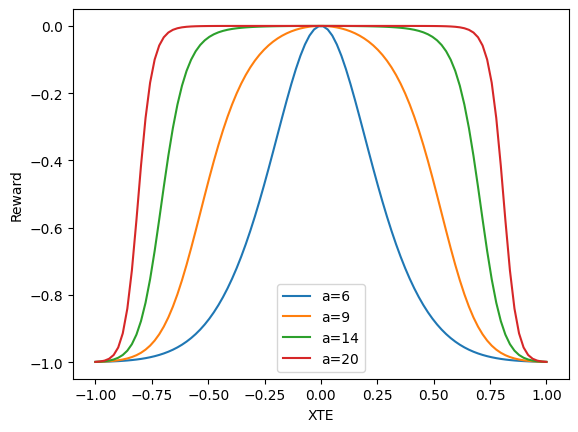

In [705]:
x = np.linspace(-1, 1, 100)

eps = 1e-3

a_list = np.logspace(.8, 1.3, 4)

for a in a_list:
  A = np.exp(-a)
  Ax = np.exp(-a*x**2)
  B = (-A+eps)/(A*(1-eps))
  y = (Ax-1)/(Ax*B+1)
  plt.plot(x, y, label=f'a={a:.0f}')

plt.xlabel('XTE')
plt.ylabel('Reward')
plt.legend()

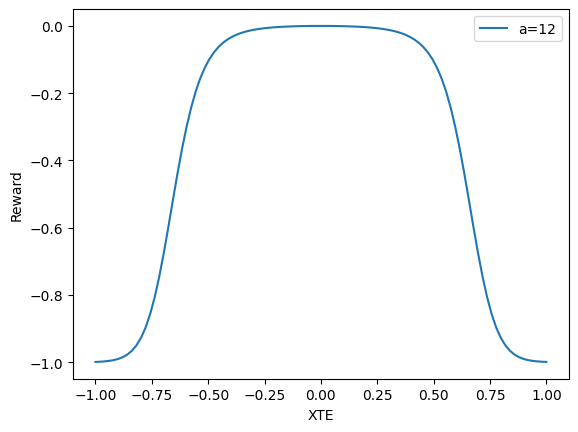

In [800]:
x = np.linspace(-1, 1, 100)

eps = 1e-3

a = 12
A = np.exp(-a)
Ax = np.exp(-a*x**2)
B = (-A+eps)/(A*(1-eps))
y = (Ax-1)/(Ax*B+1)
plt.plot(x, y, label=f'a={a:.0f}')

plt.xlabel('XTE')
plt.ylabel('Reward')
plt.legend()

0.0


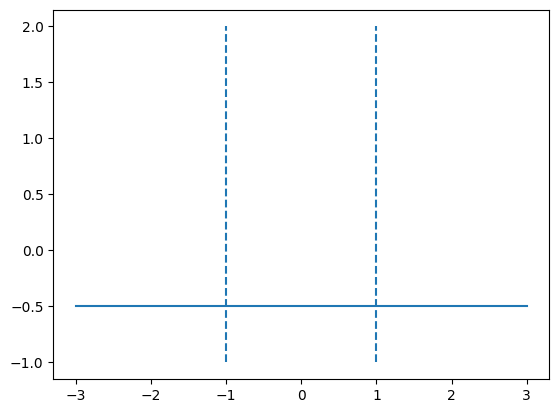

In [504]:
# xte = np.array([-1,-0.5,0])
xte = np.linspace(-3, 3, 100)

eps = .5 # 99% penalty before T, 1% penalty during [0,delta]
delta = .9

a = 2*np.log(1/eps - 1) / (1-delta**2)

print(a)

b = np.log(1/eps - 1) - a
# b = np.log((np.exp(-a*xte**2)-1)/(eps*(np.exp(-a*xte**2)+1))-1)

r = -1/(1+np.exp(-(a*(xte)**2+b)))
# r += 1/(1+np.exp(-b))
# r /= 1/(1+np.exp(-(a+b)))x
# X:x:
# a = 5
# r = 2/(1+np.exp(-a*(xte+1)))-1
# r /= 2/(1+np.exp(-a))-1

plt.plot(xte, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

# r

ValueError: x and y must have same first dimension, but have shapes (40,) and (100,)

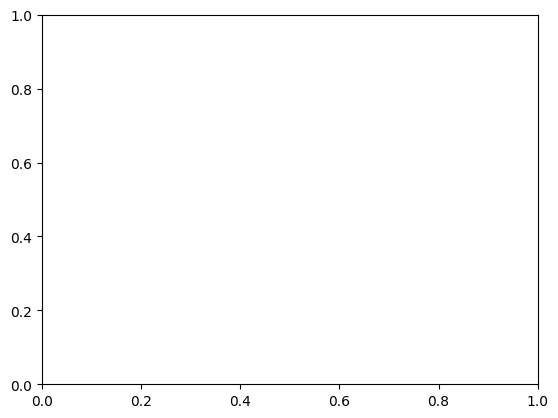

In [828]:
a = np.linspace(-10, 10, 100)
b = np.log(1/eps - 1) - a

y = 1/(1+np.exp(-b))

plt.plot(xte, y)

In [282]:
r

array([-0.89324958,  0.        , -0.89324958])

## 1D reward (min tae)

In [ ]:
heading = np.linspace(-np.pi, np.pi, 100)

r = 2*(np.exp(np.cos(heading)+1) - 1) / (np.exp(2) - 1) - 1

plt.plot(heading, r)
plt.vlines(-np.pi/2, -1, 2, linestyles='dashed')
plt.vlines(np.pi/2, -1, 2, linestyles='dashed')

## 1D reward (max vmc)

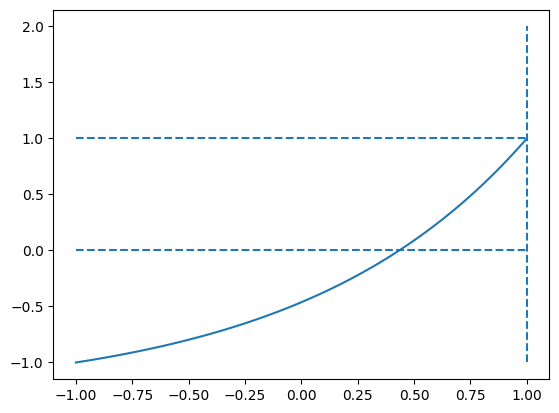

In [294]:
vmc = np.linspace(-1, 1, 100)

r = 2*(np.exp(vmc+1) - 1) / (np.exp(2) - 1) - 1

plt.plot(vmc, r)
plt.vlines(1, -1, 2, linestyles='dashed')
plt.hlines(1, -1, 1, linestyles='dashed')
plt.hlines(0, -1, 1, linestyles='dashed')

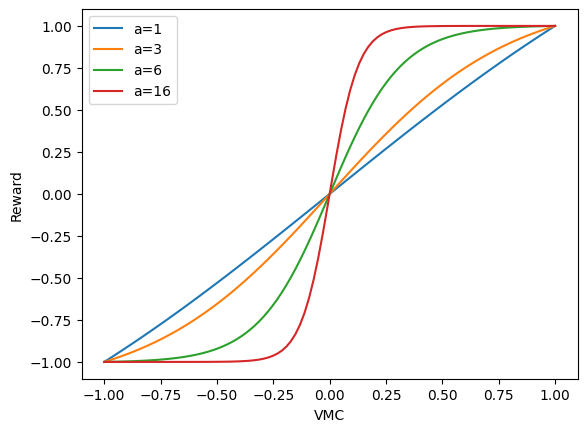

In [731]:
vmc = np.linspace(-1, 1, 100)

a_list = np.logspace(0, 1.2, 4)

for a in a_list:
  r = 2/(1+np.exp(-a*vmc))-1
  r /= ((1-np.exp(-a)/(1+np.exp(-a))) - (1-np.exp(a)/(1+np.exp(a))))
  plt.plot(vmc, r, label=f'a={a:.0f}')

plt.xlabel('VMC')
plt.ylabel('Reward')
plt.legend()

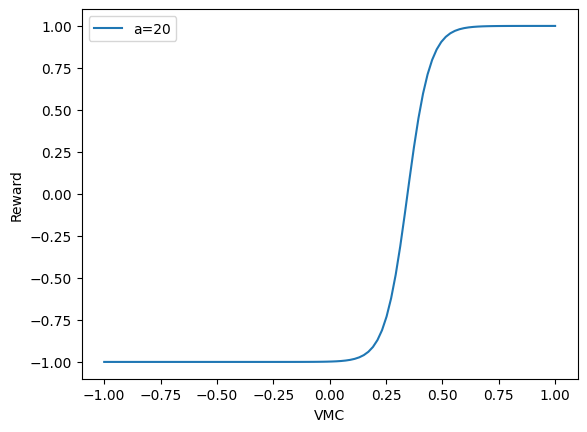

In [895]:
vmc = np.linspace(-1, 1, 100)

a = 20
r = 2*(f_sigm(a, 1-vmc) + .5)
plt.plot(vmc, r, label=f'a={a:.0f}')

plt.xlabel('VMC')
plt.ylabel('Reward')
plt.legend()

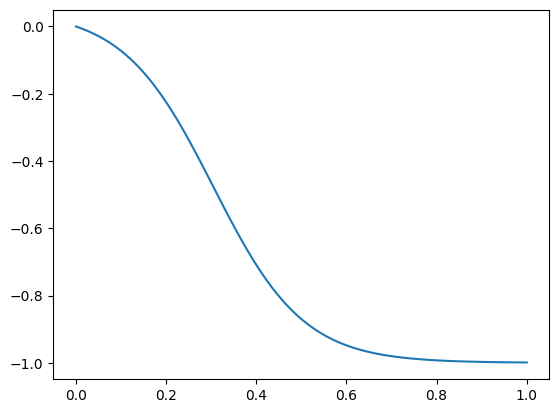

In [887]:
x = np.linspace(0, 1, 100)

eps = 1e-3
b = np.log(eps/(1-eps))
a = 1

def f_sigm(a, x):
  A = np.exp(-a)
  Ax = np.exp(-a * x)
  B = (-A + eps) / (A * (1 - eps))
  return (Ax - 1) / (Ax * B + 1)

# y -= sigm(b-a)
# y /= (sigm(b+a) - sigm(b-a))

plt.plot(x, y)

In [309]:
r

array([1.])

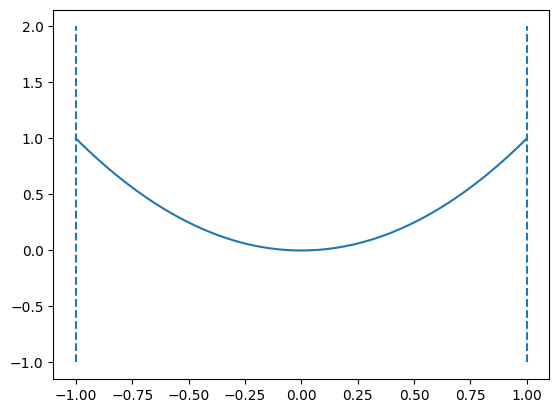

In [292]:
delta = np.linspace(-1, 1, 100)

r = delta**2

plt.plot(delta, r)
plt.vlines(-1, -1, 2, linestyles='dashed')
plt.vlines(1, -1, 2, linestyles='dashed')

In [801]:
import numpy as np
import plotly.graph_objects as go

n = 20

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1.5, 1.5, int(n*2*1))
rudder = np.linspace(-1, 1, int(n*2*1))

X, Y, Z = np.meshgrid(vmc, xte, rudder)

# XTE penalty:
a = 9
A = np.exp(-a)
Ax = np.exp(-a * Y**2)
B = (-A + eps) / (A * (1 - eps))
r_xte = (Ax - 1) / (Ax * B + 1)
print(r_xte.min(), r_xte.max())

# VMC reward
a = 6
sigm = 1 / (1 + np.exp(-a * X))
r_vmc = 2 * sigm - 1
r_vmc /= (np.exp(a) - np.exp(-a)) / (2 + np.exp(a) + np.exp(-a))
print(r_vmc.min(), r_vmc.max())

# Rudder penalty
r_rudder = -Z**2
print(r_rudder.min(), r_rudder.max())

# r_vmc = 2*(np.exp(X+1) - 1) / (np.exp(2) - 1) - 1
# r_xte = 2*(np.exp(-(Y**2-1))-1)/(np.e - 1) - 1
# r_tae = 2*(np.exp(np.cos(Z)+1) - 1) / (np.exp(2) - 1) - 1

R = r_vmc + r_xte + r_rudder

print(R.max(), R.min())

# Convert the R values into a color
colorscale = 'Viridis'
color = R.flatten()

# Plotting the data
fig = go.Figure(data=[go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode='markers',
    marker=dict(
        size=5,
        color=color,                # set color to an array/list of desired values
        colorscale=colorscale,      # choose a colorscale
        opacity=0.7,
        colorbar=dict(
            title='R Value'       # colorbar title
        )
    )
)])

# Update layout for axis labels and other settings
fig.update_layout(
    margin=dict(t=0, b=0, l=0, r=0),
    scene=dict(
        xaxis_title='VMC',
        yaxis_title='XTE',
        zaxis_title='TAE'
    )
)

fig.show()

-0.999999986981289 -0.0016498394244578729
-1.0 1.0000000000000002
-1.0 -0.0006574621959237298
0.9976926983796186 -2.999999986981289


In [796]:
import numpy as np
import plotly.graph_objects as go

n = 20

# Create the data
vmc = np.linspace(-1, 1, int(n*2*1))
xte = np.linspace(-1, 1, int(n*2*1))
eps = 1e-5  # It seems you missed defining 'eps'

X, Y = np.meshgrid(vmc, xte)

# XTE penalty:
a = 14
A = np.exp(-a)
Ax = np.exp(-a * Y**2)
B = (-A + eps) / (A * (1 - eps))
r_xte = (Ax - 1) / (Ax * B + 1)

# VMC reward
a = 9
sigm = 1 / (1 + np.exp(-a * X))
r_vmc = 2 * sigm - 1
r_vmc /= (np.exp(a) - np.exp(-a)) / (2 + np.exp(a) + np.exp(-a))

R = r_vmc + r_xte

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=R, x=X, y=Y)])
fig.update_layout(title='3D Surface Plot of R', autosize=False,
                  width=500, height=500, margin=dict(t=40, b=40, l=40, r=40),
                  scene=dict(xaxis_title='VMC', yaxis_title='XTE', zaxis_title='R'),
                  scene_camera=dict(
                      up=dict(x=0, y=0, z=1),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=-1.5, y=1.5, z=1.5)
                  ))
fig.show()

# Testing with shaped reward (max VMC & min XTE)
- **Last score:** 70.4
- **Result:** Good learning! Still noisy

In [ ]:
plot_training_evolution('08-31-maxmin-A1-5', model_folder='08-31-maxmin-A1')

In [ ]:
plot_metric(
  [
    ('08-31-maxmin-A1-5-29988/eval-*/0', 't=29988'),
    ('08-31-maxmin-A1-5-19992/eval-*/0', 't=19992'),
    ('08-31-maxmin-A1-5-9996/eval-*/0', 't=9996'),
  ],
  metric='obs/dt_theta_rudder/0',
)

In [ ]:
wind_theta = np.deg2rad(45)
wind_theta = (wind_theta + np.pi) % (2 * np.pi)

def get_init_wind_theta(wind_theta):
    # where the wind is coming from
    wind_theta = (wind_theta + np.pi) % (2 * np.pi)
    assert 0 <= wind_theta < 2 * np.pi, \
        'wind_theta must be in [0, 2*pi['
    # 90° to 270° avoiding going upwind at the beginning
    wind_theta = np.clip(wind_theta, np.pi / 2, 3 * np.pi / 2)
    wind_theta = (wind_theta - np.pi) % (2*np.pi)  # where the vector is going to
    return wind_theta

init_wind_theta = get_init_wind_theta(wind_theta)

print(wind_theta, init_wind_theta)

def _interpolate(a, b, t, duration):
  return a + (b - a) * (t / duration)

t = np.linspace(0, 1, 100)
plt.plot(t, _interpolate(np.rad2deg(init_wind_theta), np.rad2deg(wind_theta), t, 1))

In [ ]:
dt_theta_rudder = np.linspace(0, 1, 100)

r = (np.exp(-((1-dt_theta_rudder)**2)) - 1) / (np.e)

plt.plot(dt_theta_rudder, r)
plt.vlines(1, -1, 2, linestyles='dashed')
plt.hlines(1, -1, 1, linestyles='dashed')

# Is penalizing the XTE a good idea or just rewarded for being in the corridor is enough? **penalizing XTE**
- **Last score:** 74
- **Result:** Good learning! But still doing noisy actions.

In [ ]:
plot_training_evolution('08-31-maxminpenalize-A1-5', model_folder='08-31-maxminpenalize-A1')

In [ ]:
plot_training_evolution('08-31-maxminpenalize-A2-5', model_folder='08-31-maxminpenalize-A2')

In [ ]:
plot_training_evolution('08-31-maxminpenalize-A3-5', model_folder='08-31-maxminpenalize-A3')

In [ ]:
dfs = get_dfs('08-31-maxminpenalize-A1-5-99960/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot()

# Is penalizing delta rudder a good idea? **penalizing delta rudder**

In [ ]:
plot_training_evolution('08-31-maxminminrudder-A1-5', model_folder='08-31-maxminminrudder-A1')

In [ ]:
dfs = get_dfs('08-31-maxminminrudder-A1-5-99960/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='10K')

dfs = get_dfs('08-31-maxminminrudder-A1-5-69972/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='7K')

dfs = get_dfs('08-31-maxminminrudder-A1-5-39984/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/dt_theta_rudder/0'].plot(label='4K')

In [ ]:
plot_training_evolution('08-31-maxminminrudder-A2-5', model_folder='08-31-maxminminrudder-A2')

In [ ]:
# dfs = get_dfs('08-31-maxminpenalize-A1-5-99960/eval-*/0/')
# df = dfs.popitem()[1]
# df['obs/dt_theta_rudder/0'].plot()

dfs = get_dfs('08-31-maxminminrudder-A3-5-39984/eval-*-2/0/')
df = dfs.popitem()[1]
df['obs/theta_rudder/0'].diff().plot()
# plt.hlines(np.pi/2, 0, 1000, linestyles='dashed')
# plt.hlines(-np.pi/2, 0, 1000, linestyles='dashed')
# (df['obs/dt_theta_rudder/0']*.1).plot()
# plt.xlim(100, 200)

In [ ]:
plot_training_evolution('08-31-maxminminrudder-A3-5', model_folder='08-31-maxminminrudder-A3')

In [ ]:
plot_training_evolution('08-31-max2xpenalize-1-5', model_folder='08-31-max2xpenalize-1')


In [ ]:
plot_training_evolution('08-31-max2xpenalize-2-5', model_folder='08-31-max2xpenalize-2')

In [ ]:
plot_training_evolution('08-31-max2xpenalize-3-5', model_folder='08-31-max2xpenalize-3')

Found 10 files


Hparams:
+-------------------+------------------------------------------+
|        Name       |                  Value                   |
+-------------------+------------------------------------------+
|        obs        |             basic_2d_obs_v5              |
|        act        |             rudder_angle_act             |
|       reward      | max_vmc_penalize_xte_and_delta_rudder_v2 |
|  episode_duration |                   200                    |
|       n_envs      |                    7                     |
|   water_current   |                   none                   |
|        wind       |                 constant                 |
|     wind_dirs     |    [45, 90, 135, 180, 225, 270, 315]     |
| water_current_dir |                    90                    |
|  keep_sim_running |                  False                   |
|   container_tag   |                 mss1-ode                 |
|      n_steps      |                   1024                   |
|     batch_size

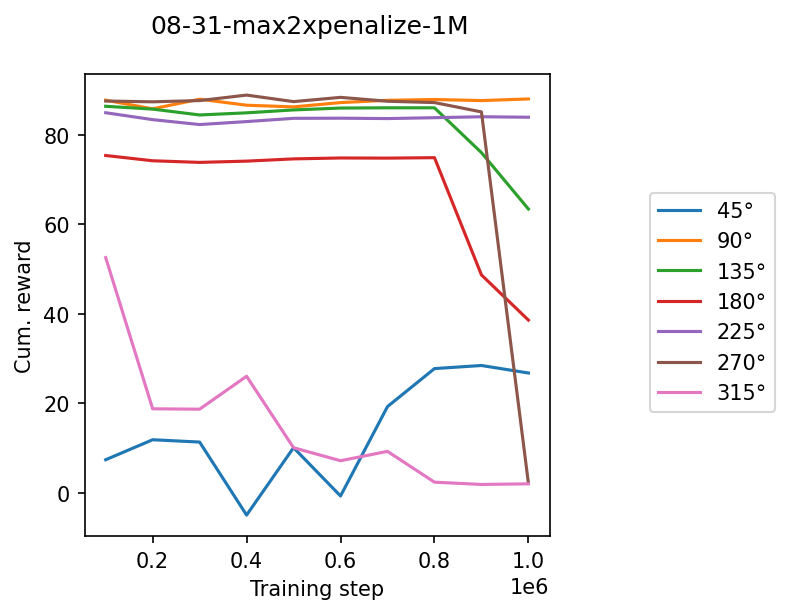

In [597]:
plot_training_evolution('08-31-max2xpenalize-1M', model_folder='08-31-max2xpenalize-delta-2')
